# Maximum Likelihood: Code

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 
import probabilistic_foundations_of_ml as pfml

**Context:** Now that we can describe our objective---to find the model parameters that maximize the probability of the observed data---we are ready to translate it into code.

**Challenge:** But how can we easily implement this optimization procedure generally? That is, how can we perform the MLE on *any model* of interest? This is the strength of a probabilistic programming language like `NumPyro`. Probabilistic programming languages provide us with the necessary *abstraction* for representing probabilistic models, so that under the hood, `NumPyro` can help us do the heavy lifting. 

**Outline:** 
* Use our knowledge of sampling from joint distribution to write down a procedure for sampling from the joint data likelihood.
* Directly translate this procedure to `NumPyro`.

## The Data Generating Process

In `NumPyro`, models are implemented as Python functions. In these functions, we describe the model's "generative process"---or, a procedure we use to sample the observed data. You just learned how to represent a whole data set using a model (using the plate notation above). We will therefore walk through a specific example that we will then code in `NumPyro`.

**Example:** We'll illustrate how to do this using an example. Suppose we want to model the joint distribution of the day-of-the-week, $D$, and whether a patient is intoxicated, $I$. We can do this via the model,
\begin{align}
p(\mathcal{D}; \pi, \rho) &= \prod\limits_{n=1}^N p_{I | D}(i_n | d_n; \rho) \cdot p_D(d_n; \pi).
\end{align}
In this model,

**(a)** *Marginal:* $p_D(\cdot; \pi)$ is a distribution over the days of the week. We will therefore define it to be a Categorical distribution:
\begin{align}
p_D(\cdot; \pi) = \mathrm{Cat}(\pi).
\end{align} 
Here, the parameter $\pi$ is a 7-dimensional array describing the probability of an observation coming from each of the 7 days of the week. That is, the probability of $D = d_n$ is given by the $d_n$-th entry of $\pi$: i.e. $p_{D}(d_n; \pi) = \pi_{d_n}$.

**(b)** *Conditional:* $p_{I | D}(\cdot | d_n; \rho)$ is the probability that a patient arrives at the ER with intoxication given that $D = d_n$. Since "intoxication" is a binary outcome, we will model it using a Bernoulli. However, recall that the probability of intoxication *changes with the day of the week*---on some days, we're more likely to treat patients with intoxication. The parameter of the Bernoulli distribution therefore needs to change depending on the day of the week. We therefore define:
\begin{align}
p_{I | D}(i_n | d_n; \rho) = \mathrm{Ber}(\rho_{d_n}).
\end{align} 
By this, we mean that $\rho$ is a 7-dimensional vector, where the $d_n$-th entry, denoted by $\rho_{d_n}$, is the probability of intoxication on day $d_n$. 

**Valid Parameter Values:** Since each entry of $\rho$ represents a Bernoulli distribution, each entry must be on between 0 and 1 (i.e. on the "unit interval"). And since $\pi$ represents a Categorical distribution, its entries must sum to 1 (a fancy name of this is that $\pi$ lies on a "simplex"). We note this briefly because we will have to communicate to `NumPyro` the valid values these parameters may take on (but don't worry, this isn't hard to do).

**Generative Process:** For this model, we assume the data was sampled (or generated) as follows:
* *Step 1:* We choose an *initial guess* for $\pi$ and $\rho$. Our guess doesn't need to be good, since `NumPyro` help us find better values via MLE.
* *Step 2:* For every $n = 1, \dots, N$:
  * *Step 2a:* We sample $d_n$ from the marginal, $d_n \sim p_D(\cdot; \pi) = \mathrm{Cat}(\pi)$. 
  * *Step 2b:* Given the specific value of $d_n$ from Step 2a, we sample from the conditional, $i_n | d_n \sim p_{I | D}(\cdot | d_n; \rho) = \mathrm{Ber}(\rho_{d_n})$.
 
This generative process is what we will translate into `NumPyro`, line for line.

````{admonition} Exercise: Practice with generative processes
**Part 1:** Write the data generative process for the IHH ER model (described in the exercise in the previous chapter)

**Part 2:** For each of the DGMs below, write the data-generating process. You can find graphical models for them in the exercise of the previous chapter.

(i) Predictive Models

(ii) Gaussian Mixture Models

(iii) Latent Dirichlet Allocation

(iv) Conditional Subspace Variational Autoencoder 

(v) Hidden Markov Models 
````

## Implementing the "Generative Process" (or Model) in `NumPyro`

Now that we have our generative process, we can go ahead and implement it in `NumPyro`. 

**The Duality of `NumPyro` Models.** Recall that, so far, we had to write two separate methods to *sample* data from a `NumPyro` model and to compute the probability of data under a `NumPyro` model. Following this approach, you'd expect that to perform the MLE, we'll need to write yet another function. But as you can see, if we had to write a function for every task we want to perform with a model, this quickly becomes cumbersome. Instead, can we only have *one* function that represents that model, from which we can both sample, evaluate the probability, and perform the MLE? This is what we will do next; we will use `NumPyro` primitives to define models that can be used for these dual purposes.

**`NumPyro` Primitives.** Specifically, we will use three `NumPyro` primitives. These primitives will communicate to `NumPyro` everything it needs to know to do the heavy lifting of sampling, evaluating, and performing the MLE. The primitives are:
* `numpyro.param`, which represents model parameters
* `numpyro.sample`, which represents an RV
* `numpyro.plate`, which represents i.i.d sampling using the "plate" notation

We'll walk you through how to use these primitives to build the model, but we additionally recommend you get in the habit of reading the [relevant documentation](https://num.pyro.ai/en/stable/primitives.html).

**Model:** We start by creating a function to represent our model:
```
def model_of_intoxication_and_day(N, d=None, i=None):
    pass
```
This function takes in several arguments:
* The total number of observations, $N$.
* Optional arrays describing the observations. That is, `d` represents an array of all $N$ days of the week, and `i` represents all $N$ binary values intoxication-yes/no. When sampling data from the model, we do not pass in `d` and `i`, but when performing the MLE, we do need to pass them in. This is because the MLE objective will try to find settings of $\pi, \rho$ that will make our observed data most likely.

Next, we can go through each step of the generative process above and translate it into `NumPyro`, line by line:

**Step 1:** We define our parameters using the `numpyro.param` primitive.
```
pi = numpyro.param(
    'pi',                          # A name used by NumPyro
    init_value=jnp.ones(7) / 7.0,  # Initial value for pi: [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]
    constraint=C.simplex,          # Entries of pi must sum to 1 (i.e. lie on a "simplex")
)

rho = numpyro.param(
    'rho',                         # A name used by NumPyro
    init_value=jnp.ones(7) * 0.5,  # Initial value for rho: [0.5, 0.5, 0.5, 0.5, 0.5. 0.5, 0.5]
    constraint=C.unit_interval,    # Each entry of rho must be in [0, 1] (i.e. lie in "unit interval")
)
```
You can find more types of constraints listed [here](https://num.pyro.ai/en/stable/_modules/numpyro/distributions/constraints.html).

**Step 2:** We create a "plate" to indicate $N$ i.i.d observations using `numpyro.plate`.
```
with numpyro.plate('data', N):
    pass
```

**Step 2a:** Inside the plate, we sample $d_n$ from the marginal, $d_n \sim p_D(\cdot; \pi) = \mathrm{Cat}(\pi)$, using `numpyro.sample`.
```
# Define marginal as Categorical using pi
p_D = D.Categorical(pi)

# Sample from the marginal
d = numpyro.sample('d', p_D, obs=d)  
```

**Step 2b:** Inside the plate, we use the specific value of $d_n$ from Step 2a to sample from the conditional, $i_n | d_n \sim p_{I | D}(\cdot | d_n; \rho) = \mathrm{Ber}(\rho_{d_n})$ using `numpyro.sample`.
```
# Define conditional as Bernoulli. Notice rho[d] to access the d-th entry of rho
p_I_given_D = D.Bernoulli(rho[d])

# Sample from the conditional 
i = numpyro.sample('i', p_I_given_D, obs=i)
```

**Putting everything together:** We now have a model that `NumPyro` understands and can perform MLE on.

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpyro
import numpyro.distributions as D
import numpyro.distributions.constraints as C


def model_of_intoxication_and_day(N, d=None, i=None):
    pi = numpyro.param(
        'pi', 
        init_value=jnp.ones(7) / 7.0, 
        constraint=C.simplex,
    )
    
    rho = numpyro.param(
        'rho', 
        init_value=jnp.ones(7) * 0.5, 
        constraint=C.unit_interval,
    )
    
    with numpyro.plate('data', N):
        p_D = D.Categorical(pi)
        d = numpyro.sample('d', p_D, obs=d)

        p_I_given_D = D.Bernoulli(rho[d])
        i = numpyro.sample('i', p_I_given_D, obs=i)

**Sampling from the Model:** We created a helper function for you, `pfml.sample_generative_process`, to sample from this model. The function takes in a `NumPyro` model, a random generator key, and then all arguments your model takes in (in this case, `N, d=None, i=None`). Note that:
* We haven't yet fit the model to the data. As such, the data we generate below will use our "initial guess" for $\pi$ and $\rho$. Later in the course, we will see why being able to sample data from a model before fitting it may be helpful.
* We pass in `None` for the observed data (i.e. `d=None, i=None`). This is because when sampling, we only want to know *how many* samples we want to generate (denoted by `N`), as opposed to giving it the data, which is only useful for evaluating the MLE objective.

In [3]:
N = 20 # Number of samples to generate
key = jrandom.PRNGKey(seed=0) # Random generator key to use

pfml.sample_generative_process(model_of_intoxication_and_day, key, N)

{'pi': Array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714], dtype=float64),
 'rho': Array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float64),
 'd': Array([1, 1, 0, 2, 5, 3, 3, 0, 1, 5, 5, 3, 4, 2, 0, 1, 1, 3, 6, 4], dtype=int64),
 'i': Array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], dtype=int64)}

**Performing the MLE:** We will now perform the MLE using another helper function we've created. Recall that the MLE for this model is:
\begin{align}
\pi^\text{MLE}, \rho^\text{MLE} &= \mathrm{argmax}_{\pi, \rho} \prod\limits_{n=1}^N p_{I | D}(i_n | d_n; \rho) \cdot p_D(d_n; \pi) \\
&= \mathrm{argmax}_{\pi, \rho} \log \prod\limits_{n=1}^N p_{I | D}(i_n | d_n; \rho) \cdot p_D(d_n; \pi) \\
&= \mathrm{argmax}_{\pi, \rho} \sum\limits_{n=1}^N \log p_{I | D}(i_n | d_n; \rho) + \log p_D(d_n; \pi)
\end{align}

First, we'll load in the data:

In [4]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-ER.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Day-of-Week,Condition,Hospitalized,Antibiotics,Knots
Patient ID,,,,,
9394,Friday,Allergic Reaction,No,No,0
898,Sunday,Allergic Reaction,Yes,Yes,0
2398,Saturday,Entangled Antennas,No,No,3
5906,Saturday,Allergic Reaction,No,No,0
2343,Monday,High Fever,Yes,No,0
8225,Thursday,High Fever,Yes,No,0
5506,Tuesday,High Fever,No,No,0
6451,Thursday,Allergic Reaction,No,No,0
2670,Sunday,Intoxication,No,No,0


Next, we introduce a helper function, `pfml.mle`, for performing the MLE. This function takes in:
* A `NumPyro` model.
* An optimizer---this is what will do the maximization. We'll cover optimization at a later chapter. For now, you can just treat them as black boxes.
* A random generator key, used by the optimizer.
* The number of iterations we'd like the optimizer to run for (this optimization algorithm is iterative).
* Finally, we pass in the arguments of the model. In this case, we pass in `N, d=d, i=i`. For our model `N` is a require argument (for the number of elements in `numpyro.plate`). You'll notice that in our model, `d` and `i` are both optional. We pass them in here to give the MLE the data (without them, how can we maximize the probability of the data?).

Putting all of this together, we get:

In [5]:
# Get data from the data frame. 
# Use our helper function, convert_day_of_week_to_int, to convert the days of the week to ints
d = jnp.array(convert_day_of_week_to_int(data['Day-of-Week']).values)
i = jnp.array((data['Condition'] == 'Intoxication').astype(int).values)

# Number of data points
N = len(d)

# Number of iterations we want the optimizer to take when maximizing the likelihood of the data
NUM_ITERATIONS = 1000

# Pick the size of update to the model's parameter during optimization
LEARNING_RATE = 0.01

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=LEARNING_RATE)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

# Perform MLE!
result = pfml.mle(
    model_of_intoxication_and_day, 
    optimizer, 
    key_optimizer,
    NUM_ITERATIONS,
    N, 
    d=d, 
    i=i,
)

100%|█| 1000/1000 [00:00<00:00, 2327.18it/s, init loss: 26390.5733, avg. loss [951-1000]: 23


Done.


The object returned to us by `pfml.mle` contains several useful components:
* `result.model_mle` is the *fitted* model. We'll need this to sample from the *fitted* model.
* `result.parameters_mle` are the parameters of the fitted model.
* `result.log_likelihood` is the joint data log-likelihood for every iteration of training. This is helpful for visualizing the convergence of the optimizer. 

**Visualizing the Convergence of the MLE:** We can plot the model's log-likelihood with each iteration of the optimizer to see whether (1) the log-likelihood is increasing, as it should, and (2) whether the optimization converged (i.e. do we think there's no more room to improve).

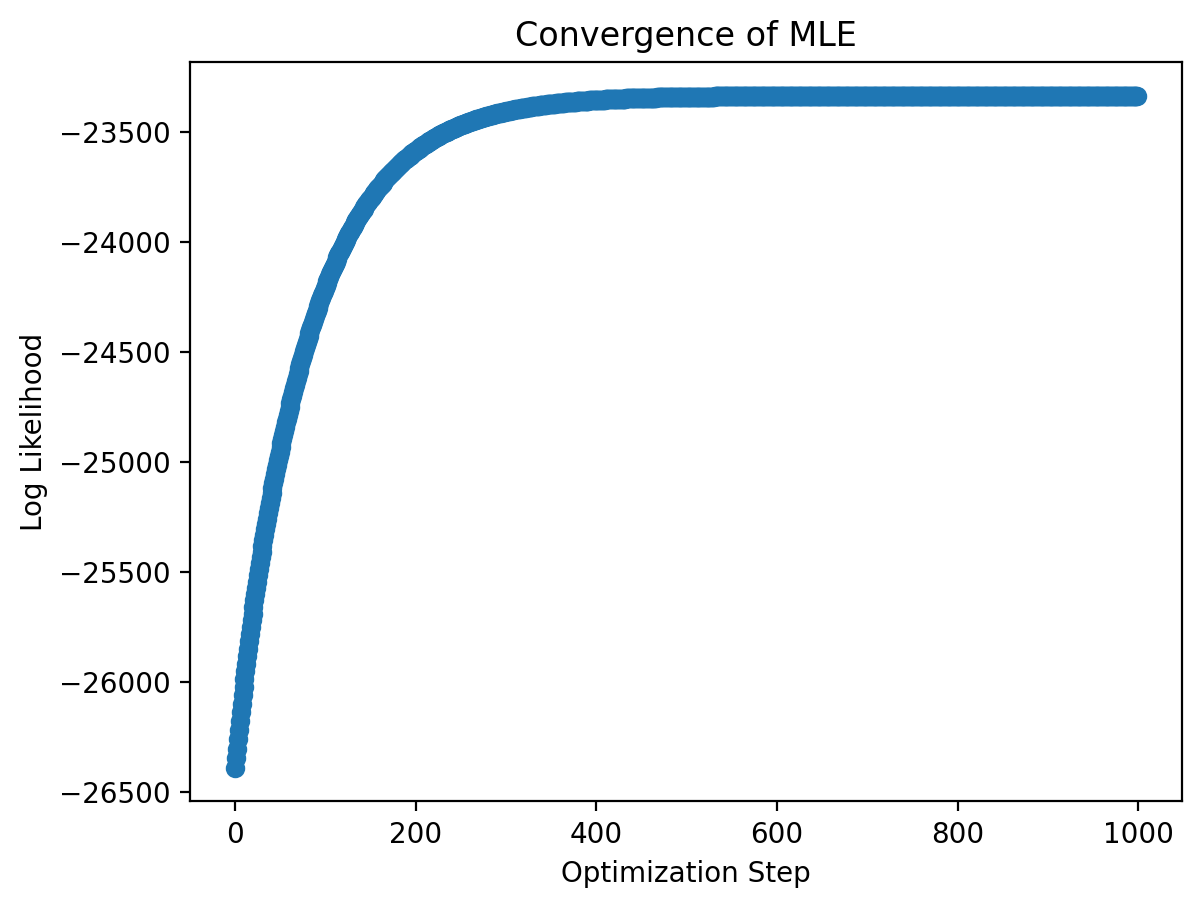

In [6]:
plt.scatter(jnp.arange(NUM_ITERATIONS), result.log_likelihood)
plt.xlabel('Optimization Step')
plt.ylabel('Log Likelihood')
plt.title('Convergence of MLE')
plt.show()

**Visualizing the Model's Parameters:** The learned model's parameters, $\pi$ and $\rho$, can be accessed as below.

In [7]:
result.parameters_mle

{'pi': Array([0.1987, 0.1529, 0.1399, 0.1419, 0.136 , 0.113 , 0.1176], dtype=float64),
 'rho': Array([0.09473922, 0.09301582, 0.09448023, 0.10785802, 0.10519358,
        0.4079646 , 0.41496599], dtype=float64)}

We can then visualize these learned probabilities to see if they match our observed data.

In [8]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

marginal_probabilities_from_data = []
conditional_probabilities_from_data = []

# Iterate over the days of the week
for day in days_of_week:
    # Select all patients that came in on the specific day of the week
    patients_on_day = data[(data['Day-of-Week'] == day)]

    # Of the selected patients, further select patients with intoxication
    patient_intoxicated_on_day = patients_on_day[patients_on_day['Condition'] == 'Intoxication']

    # Compute the portion of patients with intoxication on this day
    portion_intoxicated_on_day = float(len(patient_intoxicated_on_day)) / float(len(patients_on_day))

    # Compute the portion of patients arriving on this day
    portion_arriving_on_day = float(len(patients_on_day)) / float(len(data))
    
    marginal_probabilities_from_data.append(portion_arriving_on_day)
    conditional_probabilities_from_data.append(portion_intoxicated_on_day)

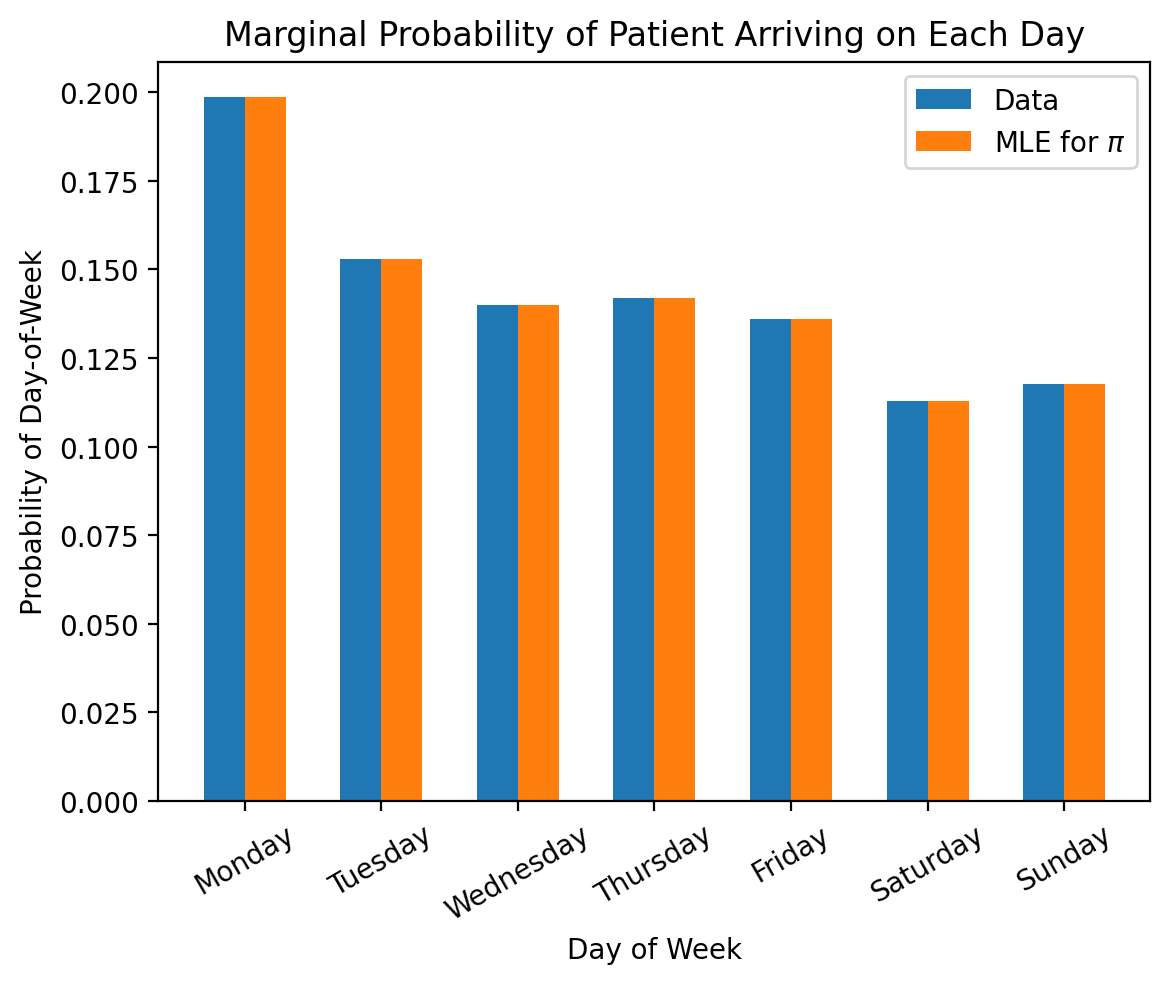

In [9]:
# Plot marginal
width = 0.3
plt.bar(jnp.arange(7) - 0.5 * width, marginal_probabilities_from_data, width, label='Data')
plt.bar(jnp.arange(7) + 0.5 * width, result.parameters_mle['pi'], width, label=r'MLE for $\pi$')

# Add axis labels and titles
plt.xticks(jnp.arange(7), days_of_week, rotation=30)
plt.xlabel('Day of Week')
plt.ylabel('Probability of Day-of-Week')
plt.title('Marginal Probability of Patient Arriving on Each Day')
plt.legend()
plt.show()

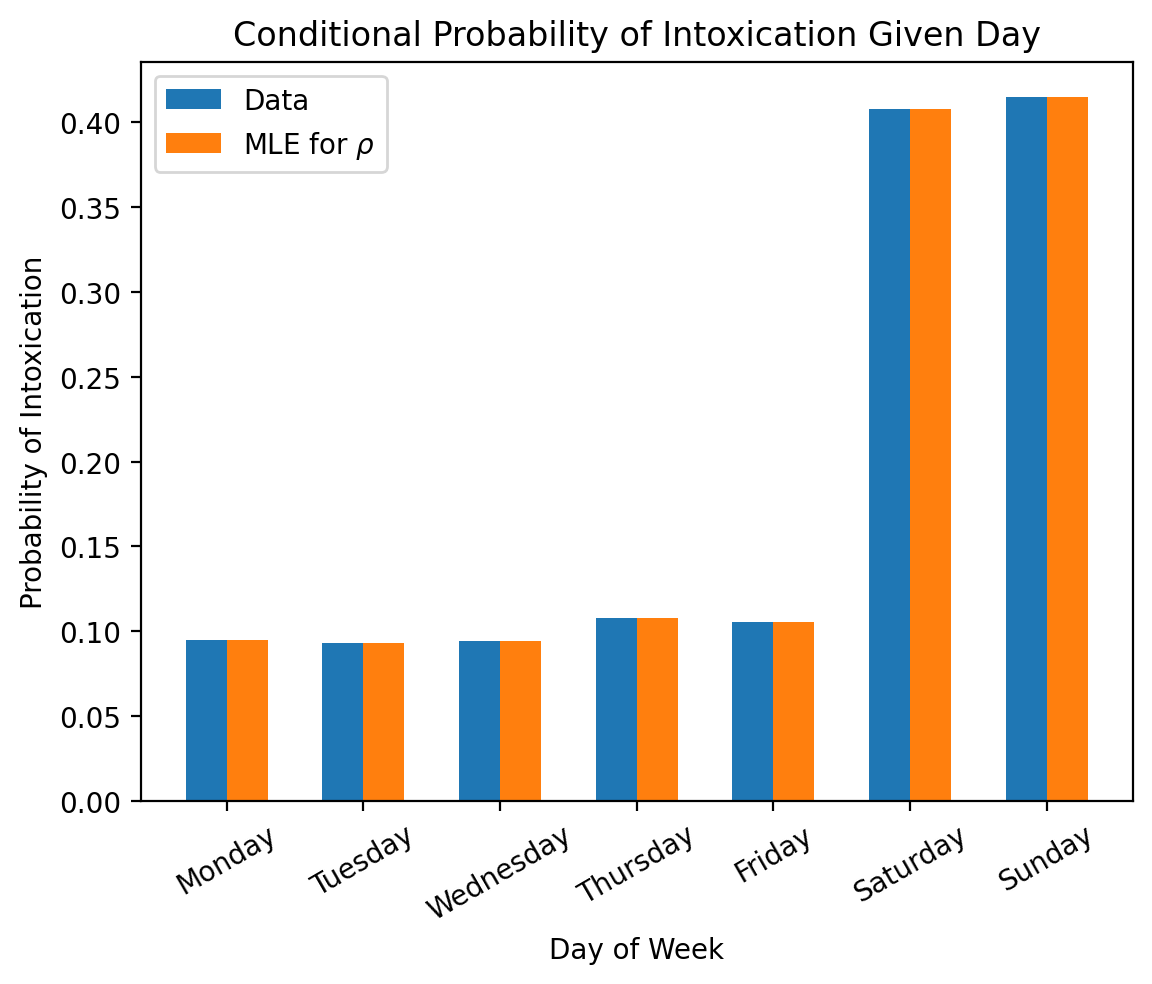

In [10]:
# Plot conditional
width = 0.3
plt.bar(jnp.arange(7) - 0.5 * width, conditional_probabilities_from_data, width, label='Data')
plt.bar(jnp.arange(7) + 0.5 * width, result.parameters_mle['rho'], width, label=r'MLE for $\rho$')

# Add axis labels and titles
plt.xticks(jnp.arange(7), days_of_week, rotation=30)
plt.xlabel('Day of Week')
plt.ylabel('Probability of Intoxication')
plt.title('Conditional Probability of Intoxication Given Day')
plt.legend()
plt.show()

**Sampling from the Fitted Model:** We can sample from the fitted model using the code below. Notice that, as with sampling before, we pass in `None` for the data (i.e. `d=None, i=None`).

In [11]:
N = 20 # Number of samples to generate
key = jrandom.PRNGKey(seed=0) # Random generator key to use

pfml.sample_generative_process(result.model_mle, key, N)

{'pi': Array([0.1987, 0.1529, 0.1399, 0.1419, 0.136 , 0.113 , 0.1176], dtype=float64),
 'rho': Array([0.09473922, 0.09301582, 0.09448023, 0.10785802, 0.10519358,
        0.4079646 , 0.41496599], dtype=float64),
 'd': Array([1, 1, 0, 1, 4, 3, 2, 0, 1, 5, 5, 3, 4, 2, 0, 0, 1, 3, 6, 4], dtype=int64),
 'i': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)}

````{admonition} Exercise: Perform the MLE on the IHH ER model

**Part 1:** You now have all of the tools necessary (1) write the data generating process for the IHH ER model in `NumPyro`, and (2) perform the MLE on the `NumPyro` model. We recommend working on parts (1) and (2) together, incrementally building the model. Specifically, we recommend adding distributions in the following order: 

a. $p_D$

b. $p_{C | D}$

c. $p_{H | C}$

d. $p_{A | C, H}$

Please use the following function signature for your model:
```
def model_of_ihh_er(N, d=None, c=None, h=None, a=None):
    pass
```

Note: Don't forget to visualize your convergence plot to make sure your training converged!

**Part 2:** Compare the parameters of each distribution (marginal and conditional) in the learned model with the distributions observed in the data (just like we did above). Do they match?

**Part 3:** Notice that so far, we've relied on a fairly large data-set. But what how good is our learned model if we have a much smaller data set, as is common in many healthcare scenarios? To test this, you can fit your model to a subsample of the data and compare the learned parameters with the distributions observed in the non-subsampled data. That is:

a. We pretend we only observe a small subsample of the data: `subsample = data.sample(50, random_state=0)`.

b. We fit the model to `subsample`.

c. We then compare the parameters of the learned model to those observed in `data`.

d. Compare your results to those from Part (2). What do you notice?
````